# Preprocessing, Feature Extraction and Modelling

In [22]:
import os
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
import seaborn as sns

In [3]:
import os
from PIL import Image, ImageOps

root_dir = './data'

# Define the target size
target_size = (256, 256)

# Output directory for resized images
output_dir = './resize_data'

# Function to resize and add padding to an image
def resize_and_add_padding(image_path, output_path):
    image = Image.open(image_path)
    image = ImageOps.fit(image, target_size, method=0, bleed=0.0, centering=(0.5, 0.5))
    image.save(output_path)

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Iterate through the "CORROSION" and "NOCORROSION" folders
for class_folder in ['CORROSION', 'NOCORROSION']:
    class_dir = os.path.join(root_dir, class_folder)

    # Create a subdirectory in the output directory for each class
    class_output_dir = os.path.join(output_dir, class_folder)
    os.makedirs(class_output_dir, exist_ok=True)

    # Iterate through the images in the class folder
    for filename in os.listdir(class_dir):
        if filename.endswith('.jpg'):  # Adjust the file extension as needed
            input_image_path = os.path.join(class_dir, filename)
            output_image_path = os.path.join(class_output_dir, filename)
            resize_and_add_padding(input_image_path, output_image_path)
            print(f"Resized: {input_image_path} -> {output_image_path}")


FileNotFoundError: [Errno 2] No such file or directory: './data/CORROSION'

## Feature Extraction

### Gray Level Co-Occurance Matrix

In [2]:
def compute_glcm_features(image_path):
    img = io.imread(image_path)
    gray = color.rgb2gray(img)
    image = img_as_ubyte(gray)
    
    bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255])  # 16-bit
    inds = np.digitize(image, bins)

    max_value = inds.max() + 1
    matrix_cooccurrence = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

    contrast = graycoprops(matrix_cooccurrence, 'contrast')
    dissimilarity = graycoprops(matrix_cooccurrence, 'dissimilarity')
    homogeneity = graycoprops(matrix_cooccurrence, 'homogeneity')
    energy = graycoprops(matrix_cooccurrence, 'energy')
    correlation = graycoprops(matrix_cooccurrence, 'correlation')
    asm = graycoprops(matrix_cooccurrence, 'ASM')

    return {
        "Contrast": contrast,
        "Dissimilarity": dissimilarity,
        "Homogeneity": homogeneity,
        "Energy": energy,
        "Correlation": correlation,
        "ASM": asm
    }

In [4]:
corrosion_dir = "resize_data/CORROSION"
nocorrosion_dir = "resize_data/NOCORROSION"

# Function to compute GLCM features for a directory of images
def compute_glcm_features_for_directory(directory, label):
    features_list = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            image_path = os.path.join(directory, filename)
            features = compute_glcm_features(image_path)
            features["Label"] = label  # Add the label
            features_list.append(features)
    return features_list

# Compute GLCM features for both classes
corrosion_features = compute_glcm_features_for_directory(corrosion_dir, "corrosion")
nocorrosion_features = compute_glcm_features_for_directory(nocorrosion_dir, "nocorrosion")

# Combine features for both classes
all_features = corrosion_features + nocorrosion_features

# Save as csv file
feature_df = pd.DataFrame(all_features)
feature_df.to_csv("./features/glcm_features.csv", index=False)


In [4]:
import pandas as pd

# Read the original DataFrame
df_data = pd.read_csv('./features/glcm_features.csv')

# Extract the 'Contrast' column and remove square brackets
df_data['Contrast'] = df_data['Contrast'].str.replace('[', '').str.replace(']', '')
df_data['Dissimilarity'] = df_data['Dissimilarity'].str.replace('[', '').str.replace(']', '')
df_data['Homogeneity'] = df_data['Homogeneity'].str.replace('[', '').str.replace(']', '')
df_data['Energy'] = df_data['Energy'].str.replace('[', '').str.replace(']', '')
df_data['Correlation'] = df_data['Correlation'].str.replace('[', '').str.replace(']', '')
df_data['ASM'] = df_data['ASM'].str.replace('[', '').str.replace(']', '')



# Split the 'Contrast' column values by whitespace and expand them into separate columns
df_data[['Contrast0', 'Contrast45', 'Contrast90', 'Contrast135']] = df_data['Contrast'].str.split(expand=True)
df_data[['Dissimilarity0', 'Dissimilarity45', 'Dissimilarity90', 'Dissimilarity135']] = df_data['Dissimilarity'].str.split(expand=True)
df_data[['Homogeneity0', 'Homogeneity45', 'Homogeneity90', 'Homogeneity135']] = df_data['Homogeneity'].str.split(expand=True)
df_data[['Energy0', 'Energy45', 'Energy90', 'Energy135']] = df_data['Energy'].str.split(expand=True)
df_data[['Correlation0', 'Correlation45', 'Correlation90', 'Correlation135']] = df_data['Correlation'].str.split(expand=True)
df_data[['ASM0', 'ASM45', 'ASM90', 'ASM135']] = df_data['ASM'].str.split(expand=True)


# Drop the original 'Contrast' column
df_data.drop(columns=['Contrast'], inplace=True)
df_data.drop(columns=['Dissimilarity'], inplace=True)
df_data.drop(columns=['Homogeneity'], inplace=True)
df_data.drop(columns=['Energy'], inplace=True)
df_data.drop(columns=['Correlation'], inplace=True)
df_data.drop(columns=['ASM'], inplace=True)


# Save the new DataFrame to a new CSV file
new_csv_filename = './features/glcm_features_split.csv'
df_data.to_csv(new_csv_filename, index=False)

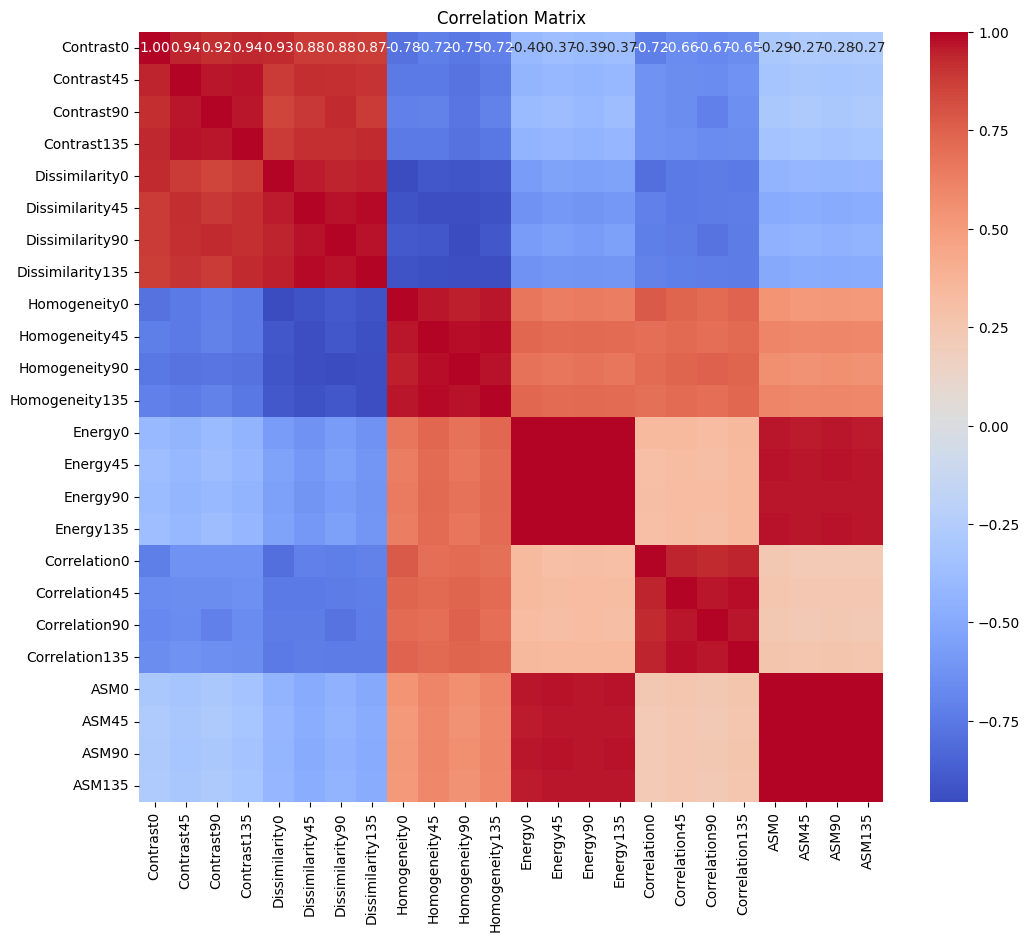

In [23]:
data = pd.read_csv('./features/glcm_features_split.csv')

correlation_matrix = data.drop('Label', axis=1).corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Show the plot
plt.title('Correlation Matrix')
plt.show()

## Tanpa PCA

In [10]:
features = data.drop('Label', axis=1)

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Encode labels (corrosion, no corrosion) to numerical values
label_encoder = LabelEncoder()
y = data['Label']
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_standardized, y, test_size=0.2, random_state=42)

# Initialize and train the MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, solver='sgd', random_state=42, verbose=False)
mlp_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mlp_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f"Classification Report:\n{classification_rep}")


Classification Report:
              precision    recall  f1-score   support

   corrosion       0.73      0.81      0.77       192
 nocorrosion       0.75      0.64      0.69       166

    accuracy                           0.73       358
   macro avg       0.74      0.73      0.73       358
weighted avg       0.74      0.73      0.73       358



/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Dengan PCA

In [ ]:
# Load your dataset (assuming 'glcm_features_new.csv')
data = pd.read_csv('./features/glcm_features_split.csv')

features = data.drop('Label', axis=1)

# Standardize the features (optional but recommended)
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)


n_components = 15

for i in range(n_components):
    # Apply PCA
    pca = PCA(n_components=i+1)
    pca.fit(features_standardized)

    # Transform the features
    features_pca = pca.transform(features_standardized)

    # Encode labels (corrosion, no corrosion) to numerical values
    label_encoder = LabelEncoder()
    y = data['Label']
    y = label_encoder.fit_transform(y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features_pca, y, test_size=0.2, random_state=42)

    # Initialize and train the MLP classifier
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(300, ), max_iter=200, random_state=42, verbose=False, solver='adam',alpha=0.0001,
                                activation='relu', learning_rate='constant')
    mlp_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = mlp_classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    # Print the results
    print(f"Accuracy: {accuracy}, pca_component = {i+1}")
print(f"Classification Report:\n{classification_rep}")


Accuracy: 0.6256983240223464, pca_component = 1
Accuracy: 0.6256983240223464, pca_component = 2
Accuracy: 0.6787709497206704, pca_component = 3
Accuracy: 0.7374301675977654, pca_component = 4


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7402234636871509, pca_component = 5


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.770949720670391, pca_component = 6


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7513966480446927, pca_component = 7


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7681564245810056, pca_component = 8


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7737430167597765, pca_component = 9


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7737430167597765, pca_component = 10


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7681564245810056, pca_component = 11


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.770949720670391, pca_component = 12


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7821229050279329, pca_component = 13


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7849162011173184, pca_component = 14
Accuracy: 0.7988826815642458, pca_component = 15
Classification Report:
              precision    recall  f1-score   support

   corrosion       0.81      0.82      0.81       192
 nocorrosion       0.79      0.77      0.78       166

    accuracy                           0.80       358
   macro avg       0.80      0.80      0.80       358
weighted avg       0.80      0.80      0.80       358



/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Saving The Model

In [26]:
import joblib

# Save the trained MLP classifier to a file
model_filename = './model/mlp_classifier_model.joblib'
joblib.dump(mlp_classifier, model_filename)

['./model/mlp_classifier_model.joblib']